# Customer Churn Modelling

### Team members: Ellisha, Ikram, Brian

This project aims to predict customer churn in Telco company. The dataset contains 7043 observations and 31 variables and can be found on [Kaggle](https://www.kaggle.com/yeanzc/telco-customer-churn-ibm-dataset).

This workbook focuses on the modelling part, where I attempt to build a model with the best result. The attempted models include logistic regression, support vector machine, decision trees, and random forest. Since the labels are imbalanced, oversampling techniques, such as SMOTE and ADASYN, are also tried. The best model is random forest and is used as the final model for the churn prediction.

## Loading Libraries

In [1]:
## Dataset manipulation
import pandas as pd 
import numpy as np 

## Visualisation
import seaborn as sns 
import matplotlib.pyplot as plt 

## Preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Oversampling
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.combine import SMOTEENN

## Train Test Split
from sklearn.model_selection import train_test_split

## Logistic Regression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

## Support Vector Machine
from sklearn import svm
from sklearn.svm import SVC, LinearSVC

## Decision Trees
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

## Random Forest and ensembles
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

## Tree Interpreter
from treeinterpreter import treeinterpreter as ti

## Evaluation metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV

## Writing Functions

### Unique Values Function

In [2]:
def unique_values(df, variable):
    
    """
    Function to print unique values and their counts for a variable
    ----------------------------------------------------------------
    df: dataframe
    variable: name of variable in string
    """
    
    print(f'The variable {variable} has {len(df[variable].unique())} unique values: \n')
    print(f'{df[variable].unique()}')
    print(f'-------------------------------------------------------------------------- \n')

### Missing Values Function

In [3]:
def missing(df):
    
    """
    Function to show the counts of missing values of each variable and their percentages out of the whole dataset
    --------------------------------------------------------------------------------------------------------------
    df: dataframe
    """
    
    variables = df.columns
    missings = df.isnull().sum()
    percent = round(missings/df.shape[0], 3)
    
    result = pd.DataFrame(list(zip(variables, missings, percent)))
    result.columns = ['Variables', 'Count', 'Percentage']
    result = result.sort_values(by = 'Count', ascending = False)
    
    print(result)

### Data Cleaning Function

In [4]:
def data_clean(df):
    
    """
    Function to clean a dataframe
    ------------------------------
    df: dataframe
    """
    
    ## Fill missing values in Churn Reason
    df['Churn Reason'] = df['Churn Reason'].fillna('Current Customer')
    
    ## Replace blank strings to 0 in Total Charges: their Tenure Months are 0, suggesting that they are new customers
    ## Convert Total Charges to float
    df['Total Charges'] = np.where(df['Total Charges'] == " ", 0, df['Total Charges'])
    df['Total Charges'] = df['Total Charges'].astype('float64')
    
    return df

### Eda Function

In [5]:
def kde_plot(df, feature):
    plt.figure(figsize = (10, 8))
    plt.title(f'KDE Plot of {feature}')
    ax0 = sns.kdeplot(df[df['Churn Label'] == 'No'][feature], color = 'navy', legend = True, label = 'Churn: No')
    ax1 = sns.kdeplot(df[df['Churn Label'] == 'Yes'][feature], color = 'orange', legend = True, label = 'Churn: Yes')
    plt.legend()
    plt.show()

### Data Engineering Function

#### Main Function

In [6]:
def data_eng(df, onehot = False, onehot_cols = None, hashing = False, hash_cols = None, binary = False, binary_cols = None,
             standardise_list = None, testing = False):
    
    """
    Function to perform feature engineering and data transformation
    ----------------------------------------------------------------
    df: dataframe
    onehot: default = False, True to perform one-hot encoding
    onehot_cols: default = None, columns to be one-hot encoded (list)
    hashing: default = False, True to perform hash encoding
    hash_cols: default = None, columns to be hash encoded (list)
    binary: default = False, True to perform binary encoding
    binary_cols: default = None, columns to be binary encoded (list)
    standardise_list: default = None, columns to be standardised using StandardScaler
    testing: default = False, True for testing dataset to be standardised
    """
    
    df_eng = df.copy()
    
    ## Creates a dictionary for mapping, then group different churn reasons together and assign to new column
    
    churn_dict = {}
    
    for key in ['Attitude of service provider', 'Attitude of support person', 
                'Poor expertise of online support', 'Poor expertise of phone support', 
                'Service dissatisfaction']:
        churn_dict[key] = 'Customer Service'
    
    for key in ['Network reliability', 'Lack of affordable download/upload speed', 
                'Product dissatisfaction', 'Lack of self-service on Website',
                'Limited range of services']:
        churn_dict[key] = 'Product Service'
        
    for key in ['Extra data charges', 'Long distance charges', 'Price too high']:
        churn_dict[key] = 'Price'
        
    for key in ['Competitor had better devices', 'Competitor made better offer', 
                'Competitor offered higher download speeds', 'Competitor offered more data']:
        churn_dict[key] = 'Competitor'
    
    for key in ['Deceased', "Don't know", 'Moved']:
        churn_dict[key] = 'Misc'
        
    churn_dict['Current Customer'] = 'Current Customer'
        
    df_eng['Churn Reason Grouped'] = df_eng['Churn Reason'].map(churn_dict)
    
    ##--------------------------------------------------------------------------------------------------------
    
    ## Combining 'No internet service' with 'No' in some of the variables
    ## The information of 'No internet service' is already captured by the variable Internet Service
    
    internet_dict = {}
    for key in ['No internet service', 'No']:
        internet_dict[key] = 'No'
        
    internet_dict['Yes'] = 'Yes'
    
    combine_cols = ['Online Security', 'Online Backup', 
                    'Device Protection', 'Tech Support', 
                    'Streaming TV', 'Streaming Movies']
    
    temp_str = ''
    
    for cols in combine_cols:
        temp_str = cols + ' Grouped'
        df_eng[temp_str] = df_eng[cols].map(internet_dict)
    
    ##--------------------------------------------------------------------------------------------------------
    
    ## Binning
    
    df_eng['Monthly Charges Bin'] = pd.cut(df_eng['Monthly Charges'], 
                                           [0, 40, 70, 200],
                                           labels = ['Low Charges', 'Medium Charges', 'High Charges'])
    df_eng['Tenure Months Bin'] = pd.cut(df_eng['Tenure Months'], 
                                         [0, 24, 200],
                                         labels = ['Recent Customers', 'Old Customers'],
                                         include_lowest = True)
    
    ##--------------------------------------------------------------------------------------------------------
    
    ## Encoding
    
    if onehot:
        
        onehot_encoder = OneHotEncoder(sparse = False, drop = 'first')
        onehot_encoded = onehot_encoder.fit_transform(df_eng[onehot_cols])
        onehot_encoded = pd.DataFrame(onehot_encoded, index = df_eng.index)
        onehot_encoded.columns = onehot_encoder.get_feature_names(onehot_cols)
        
        df_eng = df_eng.join(onehot_encoded)
        
    if hashing:
        
        hashing_encoder = ce.HashingEncoder(n_components = 8, return_df = False)
        hashing_encoded = hashing_encoder.fit_transform(df_eng[hash_cols])
        hashing_encoded = pd.DataFrame(hashing_encoded, index = df_eng.index)
        hashing_encoded.columns = hashing_encoder.get_feature_names()
        
        df_eng = df_eng.join(hashing_encoded)
        
    if binary:
        
        binary_encoder = ce.BinaryEncoder(return_df = False, drop_invariant = True)
        binary_encoded = binary_encoder.fit_transform(df_eng[binary_cols])
        binary_encoded = pd.DataFrame(binary_encoded, index = df_eng.index)
        binary_encoded.columns = binary_encoder.get_feature_names()
        
        df_eng = df_eng.join(binary_encoded)
    
    ##--------------------------------------------------------------------------------------------------------
    
    ## Standardisation
    
    if not standardise_list:
        
        return df_eng

    elif testing == False:
        
        global scaler
        scaler = StandardScaler()
        df_eng[standardise_list] = scaler.fit_transform(df_eng[standardise_list])
    
    else:
        
        scale_mean = scaler.mean_
        scale_std = scaler.scale_
        
        for i in range(len(standardise_list)):
            
            col = standardise_list[i]

            df_eng[col] = df_eng[col].apply(lambda x: (x - scale_mean[i])/scale_std[i])
    
    return df_eng

#### Oversampling Function

In [7]:
def oversamp(x, y, method = 'SMOTE', seed = 1):
    
    """ 
    Function to perform oversampling to address class imbalance issue
    ------------------------------------------------------------------
    x: feature matrix
    y: response
    method: 'ADASYN' or 'SMOTE' or 'SMOTEENN', default = 'SMOTE'
    seed: int for random state, default = 1
    """
    
    if method == 'SMOTE':
        
        oversample = SMOTE(random_state = seed)
        x_os, y_os = oversample.fit_resample(x, y)
        
    elif method == 'ADASYN':
        
        oversample = ADASYN(random_state = seed)
        x_os, y_os = oversample.fit_resample(x, y)
        
    elif method == 'SMOTEENN':
        
        oversample = SMOTEENN(random_state = seed)
        x_os, y_os = oversample.fit_resample(x, y)
    
    return x_os, y_os

### Metrics Functions

#### Accuracy, Precision, Recall

In [8]:
def apr(y_pred, y_real):
    
    """
    Function to show evaluation metrics for models
    -----------------------------------------------
    Precision [TP/(TP + FP)]: how many predicted True values are actually true
    Recall [TP/(TP + FN)]: how many actual True values can our model capture 
    F1 score {2*[(precision * recall)/(precision + recall)]}: balances precision and recall
    """
    
    accuracy = accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    return accuracy, precision, recall

#### Cross Validation Score

In [9]:
def cv_score(model, x, y, n = 5):
    
    """
    Function to show cross validation score of the model
    -----------------------------------------------------
    n: number of folds, default = 5
    """
    
    scores = cross_val_score(model, x, y, cv = n)
    average_score = np.mean(scores)
    sd = np.std(scores)
    
    print(f'Accuracy of each cv: {scores}')
    print(f'Average accuracy: {average_score}')
    print(f'Standard deviation: {sd}')

#### Confusion Matrix

In [10]:
def produce_confusion(positive_label, negative_label, cut_off, y_pred, y_real):
    
    """
    Function to show confusion matrix and accuracy of the model
    ------------------------------------------------------------
    positive_label: label for positive outcome
    negative_label: label for negative outcome
    cut_off: cut off value, above which the outcome will be classified as positive
    y_pred: predicted value of response variable
    y_real: actual value of response variable
    """
    
    # Set pred to 0 or 1 depending on whether it's higher than the cut_off point.
    pred_binary = np.where(y_pred > cut_off , 1, 0)
    
    # Build the CM
    cm = confusion_matrix(y_real, pred_binary)  
    
    ax= plt.subplot()
    sns.heatmap(cm, annot = True, ax = ax, fmt = 'g'); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels([negative_label, positive_label])
    ax.yaxis.set_ticklabels([negative_label, positive_label]);

    print('Test accuracy = ', accuracy_score(y_real, pred_binary))

#### ROC Curve

In [11]:
def produce_roc(y_pred, y_real):
    
    """
    Function to plot ROC curve and show AUC score
    ----------------------------------------------
    y_pred: predicted value of response variable
    y_real: actual value of response variable
    """
    
    logit_roc_auc = roc_auc_score(y_real, y_pred)
    fpr, tpr, thresholds = roc_curve(y_real, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = "lower right")
    plt.show()
    
    print(f'AUC = {metrics.auc(fpr, tpr)}')

## Reading in Data

In [12]:
churn_full = pd.read_excel('OneDrive\Desktop\Digital_Futures\Digital_Futures_Group_Project_3\customer_churn.xlsx')

## Data Cleaning

In [13]:
churn_full_cleaned = data_clean(churn_full)

## Train Test Split

In [14]:
columns = list(churn_full_cleaned.columns)
columns.remove('Churn Value')

X = churn_full_cleaned[columns]
y = churn_full_cleaned['Churn Value']

In [15]:
## Splitting data into 0.75 training set and 0.25 testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

## Feature Engineering and Data Transformation

In [16]:
onehot_list = ['Gender', 'Senior Citizen', 'Partner', 
               'Dependents', 'Phone Service', 'Multiple Lines', 
               'Internet Service', 'Online Security', 'Online Backup', 
               'Device Protection', 'Tech Support', 'Streaming TV',
               'Streaming Movies', 'Contract', 'Paperless Billing', 
               'Payment Method', 'Online Security Grouped',
               'Online Backup Grouped', 'Device Protection Grouped',
               'Tech Support Grouped', 'Streaming TV Grouped',
               'Streaming Movies Grouped', 'Monthly Charges Bin',
               'Tenure Months Bin']

In [17]:
scale_list = ['Tenure Months', 'Monthly Charges', 'Total Charges']

### Training Set

In [18]:
X_train_eng = data_eng(X_train, onehot = True, onehot_cols = onehot_list,
                       standardise_list = scale_list, testing = False)

In [19]:
X_train_eng.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Payment Method_Mailed check,Online Security Grouped_Yes,Online Backup Grouped_Yes,Device Protection Grouped_Yes,Tech Support Grouped_Yes,Streaming TV Grouped_Yes,Streaming Movies Grouped_Yes,Monthly Charges Bin_Low Charges,Monthly Charges Bin_Medium Charges,Tenure Months Bin_Recent Customers
6464,6549-BTYPG,1,United States,California,Sebastopol,95472,"38.398815, -122.861923",38.398815,-122.861923,Female,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
5707,6050-IJRHS,1,United States,California,Chino Hills,91709,"33.942895, -117.725644",33.942895,-117.725644,Female,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3442,4223-BKEOR,1,United States,California,San Bernardino,92411,"34.122501, -117.320138",34.122501,-117.320138,Female,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3932,3904-UKFRE,1,United States,California,Stockton,95205,"37.965695, -121.260051",37.965695,-121.260051,Male,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6124,1722-LDZJS,1,United States,California,Sanger,93657,"36.819628, -119.440414",36.819628,-119.440414,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
scaler.mean_

array([  32.36160545,   64.62659031, 2272.85525369])

#### Oversampling

In [21]:
X_train_eng_os = X_train_eng.copy()
y_train_os = y_train.copy()

In [22]:
X_train_eng_os.drop(['CustomerID', 'Count', 'Country', 
                     'State', 'City', 'Zip Code', 'Lat Long',
                     'Latitude', 'Longitude', 'Gender',
                     'Senior Citizen', 'Partner', 'Dependents',
                     'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security',
                     'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
                     'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
                     'Churn Label', 'Churn Reason', 'Churn Reason Grouped',
                     'Online Security Grouped', 'Online Backup Grouped',
                     'Device Protection Grouped', 'Tech Support Grouped',
                     'Streaming TV Grouped', 'Streaming Movies Grouped',
                     'Monthly Charges Bin', 'Tenure Months Bin'], axis = 1, inplace = True)

In [23]:
X_train_eng_os, y_train_os = oversamp(X_train_eng_os, y_train_os, method = 'SMOTE', seed = 1)

In [24]:
y_train_os.value_counts()

0    3879
1    3879
Name: Churn Value, dtype: int64

### Testing Set

In [25]:
X_test_eng = data_eng(X_test, onehot = True, onehot_cols = onehot_list,
                      standardise_list = scale_list, testing = True)

In [26]:
X_test_eng.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Payment Method_Mailed check,Online Security Grouped_Yes,Online Backup Grouped_Yes,Device Protection Grouped_Yes,Tech Support Grouped_Yes,Streaming TV Grouped_Yes,Streaming Movies Grouped_Yes,Monthly Charges Bin_Low Charges,Monthly Charges Bin_Medium Charges,Tenure Months Bin_Recent Customers
941,3656-TKRVZ,1,United States,California,Chula Vista,91910,"32.636792, -117.054989",32.636792,-117.054989,Female,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1404,4919-IKATY,1,United States,California,Joshua Tree,92252,"34.167236, -116.281511",34.167236,-116.281511,Male,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5515,4584-LBNMK,1,United States,California,Portola,96122,"39.786755, -120.445626",39.786755,-120.445626,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3684,5968-HYJRZ,1,United States,California,Kerman,93630,"36.727418, -120.123526",36.727418,-120.123526,Male,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7017,2274-XUATA,1,United States,California,Earp,92242,"34.137742, -114.36514",34.137742,-114.365140,Male,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


## Benchmark

In [27]:
worse_model = [0] * len(y_test)

In [28]:
print(classification_report(y_test, worse_model))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1295
           1       0.00      0.00      0.00       466

    accuracy                           0.74      1761
   macro avg       0.37      0.50      0.42      1761
weighted avg       0.54      0.74      0.62      1761



C:\Users\brian\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brian\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brian\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression

### Model Training

In [29]:
X_train_eng.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Reason',
       'Churn Reason Grouped', 'Online Security Grouped',
       'Online Backup Grouped', 'Device Protection Grouped',
       'Tech Support Grouped', 'Streaming TV Grouped',
       'Streaming Movies Grouped', 'Monthly Charges Bin', 'Tenure Months Bin',
       'Gender_Male', 'Senior Citizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'Phone Service_Yes', 'Multiple Lines_No phone service',
       'Multiple Lines_Yes', 'Internet Service_Fiber optic',
       'Internet Service_No', 'Online Securit

In [30]:
## Feature Columns to be modelled

features = ['Tenure Months', 
            #'Monthly Charges', 
            #'Total Charges',  
            #'Gender_Male', 
            #'Senior Citizen_Yes', 
            'Partner_Yes', 
            'Dependents_Yes', 
            #'Phone Service_Yes',
            #'Multiple Lines_No phone service', 'Multiple Lines_Yes',
            'Internet Service_Fiber optic', 'Internet Service_No',
            #'Online Security_No internet service', 'Online Security_Yes',
            #'Online Backup_No internet service', 'Online Backup_Yes',
            #'Device Protection_No internet service', 'Device Protection_Yes',
            #'Tech Support_No internet service', 'Tech Support_Yes',
            #'Streaming TV_No internet service', 'Streaming TV_Yes',
            #'Streaming Movies_No internet service', 'Streaming Movies_Yes',
            'Contract_One year', 'Contract_Two year', 
            'Paperless Billing_Yes',
            #'Payment Method_Credit card (automatic)', 'Payment Method_Electronic check', 'Payment Method_Mailed check',
            'Online Security Grouped_Yes', 
            #'Online Backup Grouped_Yes',
            #'Device Protection Grouped_Yes', 
            'Tech Support Grouped_Yes',
            'Streaming TV Grouped_Yes', 
            'Streaming Movies Grouped_Yes',
            #'Monthly Charges Bin_Low Charges', 'Monthly Charges Bin_Medium Charges',
            #'Tenure Months Bin_Recent Customers'
            ]

In [31]:
## Feature matrix
X_logit = X_train_eng[features]
X_logit = sm.add_constant(X_logit)

## Create and fit the model
lg_reg = sm.Logit(y_train, X_logit).fit()

## Get predictions
predicted_logit = lg_reg.predict(X_logit)

print(lg_reg.summary())

Optimization terminated successfully.
         Current function value: 0.402555
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Churn Value   No. Observations:                 5282
Model:                          Logit   Df Residuals:                     5269
Method:                           MLE   Df Model:                           12
Date:                Tue, 25 May 2021   Pseudo R-squ.:                  0.3046
Time:                        16:34:44   Log-Likelihood:                -2126.3
converged:                       True   LL-Null:                       -3057.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.2971      0.121    -10.686      0.000

Test accuracy =  0.8072699734948883


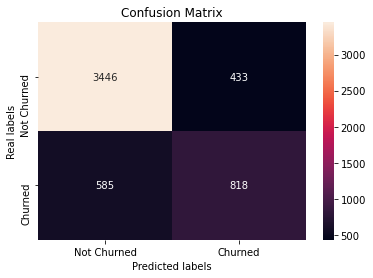

In [32]:
produce_confusion('Churned', 'Not Churned', 0.5, predicted_logit, y_train)

In [33]:
cutoff = 0.5
predicted_logit_bin = np.where(predicted_logit > cutoff , 1, 0)
apr(predicted_logit_bin, y_train)

Accuracy: 0.8072699734948883
Precision: 0.653876898481215
Recall: 0.5830363506771205
F1: 0.6164280331574982


(0.8072699734948883, 0.653876898481215, 0.5830363506771205)

In [34]:
print(classification_report(y_train, predicted_logit_bin))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3879
           1       0.65      0.58      0.62      1403

    accuracy                           0.81      5282
   macro avg       0.75      0.74      0.74      5282
weighted avg       0.80      0.81      0.80      5282



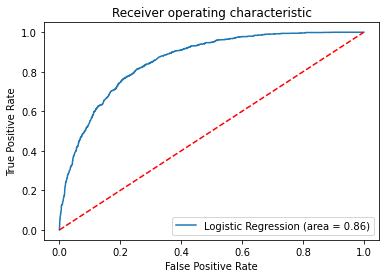

AUC = 0.8575606869013606


In [35]:
produce_roc(predicted_logit, y_train)

### Model Testing

In [36]:
X_logit_test = X_test_eng[features]
X_logit_test = sm.add_constant(X_logit_test)

predicted_logit_test = lg_reg.predict(X_logit_test)

Test accuracy =  0.8040885860306644


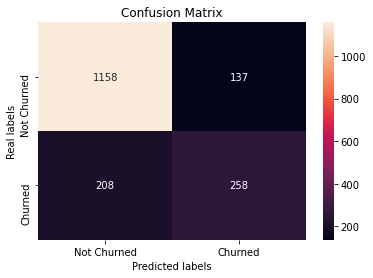

In [37]:
produce_confusion('Churned', 'Not Churned', 0.5, predicted_logit_test, y_test)

In [38]:
predicted_logit_test_bin = np.where(predicted_logit_test > cutoff , 1, 0)
apr(predicted_logit_test_bin, y_test)

Accuracy: 0.8040885860306644
Precision: 0.6531645569620254
Recall: 0.5536480686695279
F1: 0.5993031358885017


(0.8040885860306644, 0.6531645569620254, 0.5536480686695279)

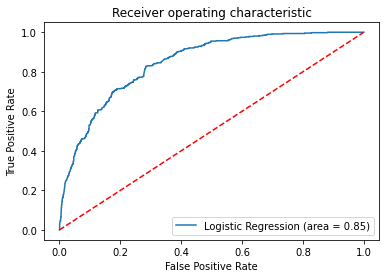

AUC = 0.8475524881104279


In [39]:
produce_roc(predicted_logit_test, y_test)

## Logistic Regression (Oversampling)

### Model Training

In [40]:
X_train_eng_os.columns

Index(['Tenure Months', 'Monthly Charges', 'Total Charges', 'Gender_Male',
       'Senior Citizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'Phone Service_Yes', 'Multiple Lines_No phone service',
       'Multiple Lines_Yes', 'Internet Service_Fiber optic',
       'Internet Service_No', 'Online Security_No internet service',
       'Online Security_Yes', 'Online Backup_No internet service',
       'Online Backup_Yes', 'Device Protection_No internet service',
       'Device Protection_Yes', 'Tech Support_No internet service',
       'Tech Support_Yes', 'Streaming TV_No internet service',
       'Streaming TV_Yes', 'Streaming Movies_No internet service',
       'Streaming Movies_Yes', 'Contract_One year', 'Contract_Two year',
       'Paperless Billing_Yes', 'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check', 'Payment Method_Mailed check',
       'Online Security Grouped_Yes', 'Online Backup Grouped_Yes',
       'Device Protection Grouped_Yes', 'Tech Sup

In [41]:
## Feature Columns to be modelled

features_os = ['Tenure Months', 
            #'Monthly Charges', 
            'Total Charges',  
            #'Gender_Male', 
            #'Senior Citizen_Yes', 
            'Partner_Yes', 
            'Dependents_Yes', 
            #'Phone Service_Yes',
            #'Multiple Lines_No phone service', 'Multiple Lines_Yes',
            'Internet Service_Fiber optic', 'Internet Service_No',
            #'Online Security_No internet service', 'Online Security_Yes',
            #'Online Backup_No internet service', 'Online Backup_Yes',
            #'Device Protection_No internet service', 'Device Protection_Yes',
            #'Tech Support_No internet service', 'Tech Support_Yes',
            #'Streaming TV_No internet service', 'Streaming TV_Yes',
            #'Streaming Movies_No internet service', 'Streaming Movies_Yes',
            'Contract_One year', 'Contract_Two year', 
            'Paperless Billing_Yes',
            #'Payment Method_Credit card (automatic)', 'Payment Method_Electronic check', 'Payment Method_Mailed check',
            'Online Security Grouped_Yes', 
            #'Online Backup Grouped_Yes',
            #'Device Protection Grouped_Yes', 
            'Tech Support Grouped_Yes',
            'Streaming TV Grouped_Yes', 
            'Streaming Movies Grouped_Yes']

In [42]:
## Feature matrix
X_logit_os = X_train_eng_os[features_os]
X_logit_os = sm.add_constant(X_logit_os)

## Create and fit the model
lg_reg_os = sm.Logit(y_train_os, X_logit_os).fit()

## Get predictions
predicted_logit_os = lg_reg_os.predict(X_logit_os)

print(lg_reg_os.summary())

Optimization terminated successfully.
         Current function value: 0.450540
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            Churn Value   No. Observations:                 7758
Model:                          Logit   Df Residuals:                     7744
Method:                           MLE   Df Model:                           13
Date:                Tue, 25 May 2021   Pseudo R-squ.:                  0.3500
Time:                        16:34:44   Log-Likelihood:                -3495.3
converged:                       True   LL-Null:                       -5377.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.1571      0.096     -1.636      0.102

Test accuracy =  0.7898943026553236


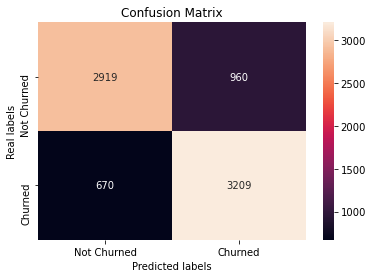

In [43]:
produce_confusion('Churned', 'Not Churned', 0.5, predicted_logit_os, y_train_os)

In [44]:
cutoff = 0.5
predicted_logit_bin_os = np.where(predicted_logit_os > cutoff , 1, 0)
apr(predicted_logit_bin_os, y_train_os)

Accuracy: 0.7898943026553236
Precision: 0.7697289517869993
Recall: 0.8272750708945604
F1: 0.7974652087475148


(0.7898943026553236, 0.7697289517869993, 0.8272750708945604)

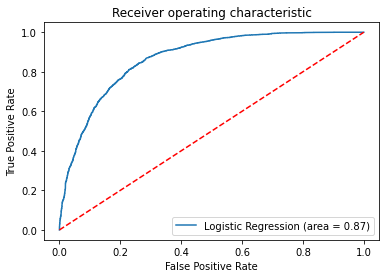

AUC = 0.8673840560162233


In [45]:
produce_roc(predicted_logit_os, y_train_os)

### Model Testing

In [46]:
X_logit_test_os = X_test_eng[features_os]
X_logit_test_os = sm.add_constant(X_logit_test_os)

predicted_logit_test_os = lg_reg_os.predict(X_logit_test_os)

Test accuracy =  0.7524134014764339


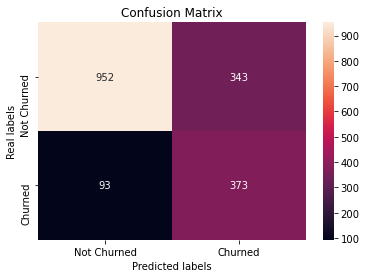

In [47]:
produce_confusion('Churned', 'Not Churned', 0.5, predicted_logit_test_os, y_test)

In [48]:
cutoff = 0.5
predicted_logit_test_bin_os = np.where(predicted_logit_test_os > cutoff , 1, 0)
apr(predicted_logit_test_bin_os, y_test)

Accuracy: 0.7524134014764339
Precision: 0.520949720670391
Recall: 0.8004291845493562
F1: 0.6311336717428088


(0.7524134014764339, 0.520949720670391, 0.8004291845493562)

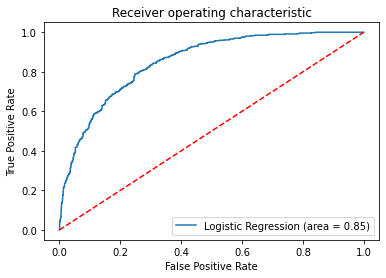

AUC = 0.850528609541485


In [49]:
produce_roc(predicted_logit_test_os, y_test)

## Support Vector Machine

### Model Training

In [50]:
features_svm = ['Tenure Months', 
                #'Monthly Charges', 
                'Total Charges',  
                #'Gender_Male', 
                'Senior Citizen_Yes', 
                'Partner_Yes', 
                'Dependents_Yes', 
                'Phone Service_Yes',
                #'Multiple Lines_No phone service', 'Multiple Lines_Yes',
                'Internet Service_Fiber optic', 'Internet Service_No',
                #'Online Security_No internet service', 'Online Security_Yes',
                #'Online Backup_No internet service', 'Online Backup_Yes',
                #'Device Protection_No internet service', 'Device Protection_Yes',
                #'Tech Support_No internet service', 'Tech Support_Yes',
                #'Streaming TV_No internet service', 'Streaming TV_Yes',
                #'Streaming Movies_No internet service', 'Streaming Movies_Yes',
                'Contract_One year', 'Contract_Two year', 
                'Paperless Billing_Yes',
                #'Payment Method_Credit card (automatic)', 'Payment Method_Electronic check', 'Payment Method_Mailed check',
                'Online Security Grouped_Yes', 
                #'Online Backup Grouped_Yes',
                #'Device Protection Grouped_Yes', 
                'Tech Support Grouped_Yes',
                'Streaming TV Grouped_Yes', 
                'Streaming Movies Grouped_Yes',
                'Monthly Charges Bin_Low Charges', 'Monthly Charges Bin_Medium Charges',
                'Tenure Months Bin_Recent Customers'
               ]

In [51]:
X_svm = X_train_eng[features_svm]

In [52]:
svm_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
                  {'kernel': ['poly'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]}]

grid_svm = GridSearchCV(SVC(), svm_parameters, scoring = 'accuracy', verbose = 4)
grid_svm.fit(X_svm, y_train)

grid_svm.best_params_

In [53]:
svm_model = SVC(gamma = 'scale',
                kernel = 'rbf',
                C = 10,
                probability = True)

svm_model.fit(X_svm, y_train)

SVC(C=10, probability=True)

In [54]:
apr(svm_model.predict(X_svm), y_train)

Accuracy: 0.8271488072699735
Precision: 0.7001633986928104
Recall: 0.6108339272986457
F1: 0.652455272173582


(0.8271488072699735, 0.7001633986928104, 0.6108339272986457)

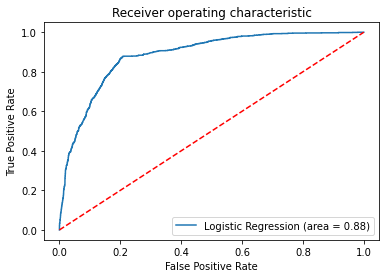

AUC = 0.8848455148131182


In [55]:
produce_roc(svm_model.predict_proba(X_svm)[:, 1], y_train)

In [56]:
cv_score(svm_model, X_svm, y_train)

Accuracy of each cv: [0.78997162 0.78807947 0.78693182 0.80208333 0.81439394]
Average accuracy: 0.7962920357787908
Standard deviation: 0.01054728052465637


### Model Testing

In [57]:
apr(svm_model.predict(X_test_eng[features_svm]), y_test)

Accuracy: 0.8069278818852924
Precision: 0.6632124352331606
Recall: 0.5493562231759657
F1: 0.6009389671361501


(0.8069278818852924, 0.6632124352331606, 0.5493562231759657)

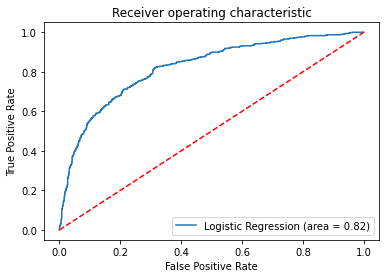

AUC = 0.8210789268729183


In [58]:
produce_roc(svm_model.predict_proba(X_test_eng[features_svm])[:, 1], y_test)

## Decision Trees

### Model Training

In [59]:
grid_tree = GridSearchCV(estimator = DecisionTreeClassifier(),
                         param_grid = {'max_depth': [3, 5, 7, 10],
                                       'min_samples_split': [5, 10, 15, 20],
                                       'min_samples_leaf': [2, 3, 4, 5, 6, 7]},
                         cv = 5,
                         refit = True,
                         verbose = 1,
                         scoring = 'accuracy')

In [60]:
grid_tree.fit(X_train_eng[features], y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                         'min_samples_split': [5, 10, 15, 20]},
             scoring='accuracy', verbose=1)

In [61]:
print(f'Best model: {grid_tree.best_estimator_}')
print(f'Best score: {grid_tree.best_score_}')

Best model: DecisionTreeClassifier(max_depth=7, min_samples_leaf=7, min_samples_split=5)
Best score: 0.7993235930735931


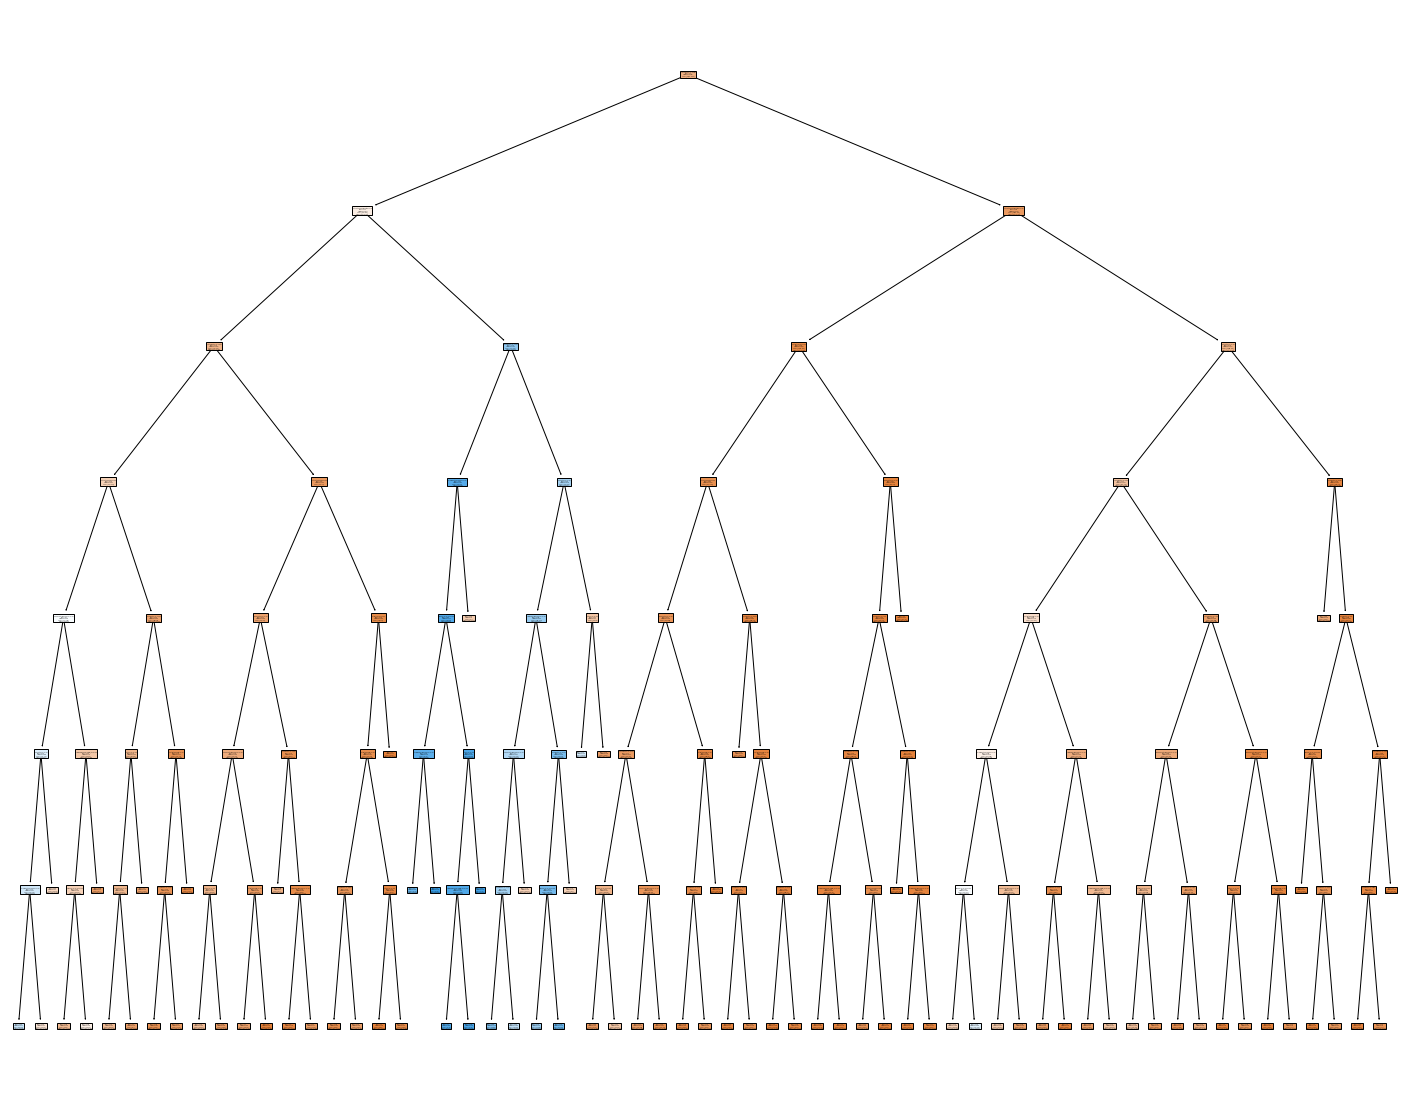

In [62]:
tree_model = DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 7, min_samples_split = 40, random_state = 1)
tree_model.fit(X_train_eng[features], y_train)

fig = plt.figure(figsize = (25, 20))
_ = tree.plot_tree(tree_model, 
                   feature_names = features,  
                   class_names = ['Not Churned', 'Churned'],
                   filled = True)

In [63]:
apr(tree_model.predict(X_train_eng[features]), y_train)

Accuracy: 0.8135176069670579
Precision: 0.6602760736196319
Recall: 0.6136849607982894
F1: 0.6361285555966014


(0.8135176069670579, 0.6602760736196319, 0.6136849607982894)

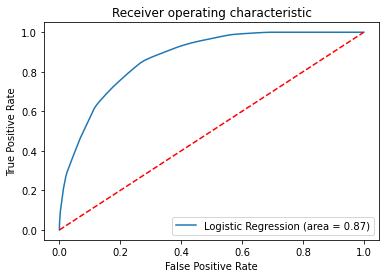

AUC = 0.8705156537651705


In [64]:
produce_roc(tree_model.predict_proba(X_train_eng[features])[:, 1], y_train)

### Model Testing

In [65]:
apr(tree_model.predict(X_test_eng[features]), y_test)

Accuracy: 0.8057921635434412
Precision: 0.6497584541062802
Recall: 0.5772532188841202
F1: 0.6113636363636363


(0.8057921635434412, 0.6497584541062802, 0.5772532188841202)

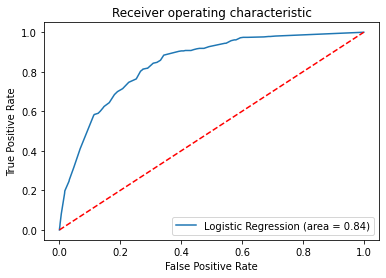

AUC = 0.8407427046912026


In [66]:
produce_roc(tree_model.predict_proba(X_test_eng[features])[:, 1], y_test)

In [67]:
importance = pd.DataFrame(zip(features, tree_model.feature_importances_))
importance.columns = ['Features', 'Importance']
importance.sort_values(by = 'Importance', ascending = False)

,Features,Importance
0,Tenure Months,0.440284
3,Internet Service_Fiber optic,0.320207
2,Dependents_Yes,0.085486
4,Internet Service_No,0.047438
8,Online Security Grouped_Yes,0.021250
5,Contract_One year,0.019521
9,Tech Support Grouped_Yes,0.017257
6,Contract_Two year,0.014621
10,Streaming TV Grouped_Yes,0.011730
7,Paperless Billing_Yes,0.011627


## Random Forest - Final Model Used

### Model Training

In [68]:
grid_rf = GridSearchCV(estimator = RandomForestClassifier(),
                         param_grid = {'class_weight': ['balanced'],
                                       'n_estimators': [50, 100, 500],
                                       'max_depth': [3, 5, 7, 10],
                                       'min_samples_split': [5, 10, 15, 20],
                                       'min_samples_leaf': [2, 3, 4, 5, 6, 7]},
                         cv = 5,
                         refit = True,
                         verbose = 3,
                         scoring = 'accuracy')

grid_rf.fit(X_train_eng[features], y_train)

- If time allows, perform a randomised search

print(f'Best model: {grid_rf.best_estimator_}')
print(f'Best score: {grid_rf.best_score_}')

In [69]:
rf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 2, min_samples_split = 10,
                            n_estimators = 500, max_features = 'auto', random_state = 1, class_weight = 'balanced')
rf.fit(X_train_eng[features], y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=500, random_state=1)

In [70]:
apr(rf.predict(X_train_eng[features]), y_train)

Accuracy: 0.8059447179098826
Precision: 0.5918367346938775
Recall: 0.8681397006414825
F1: 0.7038428199942214


(0.8059447179098826, 0.5918367346938775, 0.8681397006414825)

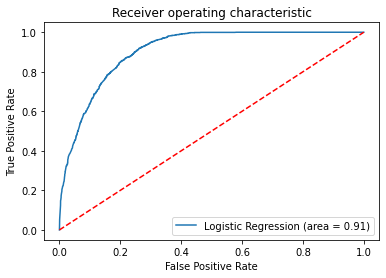

AUC = 0.9059387711340025


In [71]:
produce_roc(rf.predict_proba(X_train_eng[features])[:, 1], y_train)

### Model Testing

In [72]:
apr(rf.predict(X_test_eng[features]), y_test)

Accuracy: 0.7722884724588303
Precision: 0.5487256371814093
Recall: 0.7854077253218884
F1: 0.6460723742277141


(0.7722884724588303, 0.5487256371814093, 0.7854077253218884)

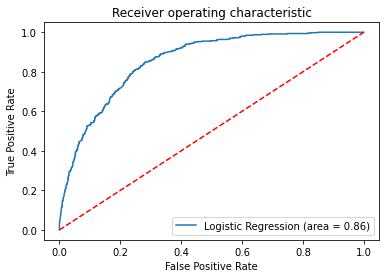

AUC = 0.8556672245513447


In [73]:
produce_roc(rf.predict_proba(X_test_eng[features])[:, 1], y_test)

In [74]:
importance_rf = pd.DataFrame(zip(features, rf.feature_importances_))
importance_rf.columns = ['Features', 'Importance']
importance_rf.sort_values(by = 'Importance', ascending = False)

,Features,Importance
0,Tenure Months,0.307404
6,Contract_Two year,0.144408
3,Internet Service_Fiber optic,0.129533
2,Dependents_Yes,0.101315
4,Internet Service_No,0.072196
5,Contract_One year,0.071899
8,Online Security Grouped_Yes,0.035758
9,Tech Support Grouped_Yes,0.033867
7,Paperless Billing_Yes,0.032521
1,Partner_Yes,0.027269


## Generating Customer List

In [75]:
Customer_full = data_eng(churn_full_cleaned, onehot = True, onehot_cols = onehot_list,
                    standardise_list = scale_list)

In [76]:
Customer_full['Churn Risk'] = rf.predict_proba(Customer_full[features])[:, 1]

In [77]:
Customer_full[['Churn Risk', 'Churn Value']]

,Churn Risk,Churn Value
0,0.768083,1
1,0.848376,1
2,0.796363,1
3,0.363280,1
4,0.356314,1
...,...,...
7038,0.000840,0
7039,0.040596,0
7040,0.019776,0
7041,0.198227,0


In [78]:
Customer = Customer_full[Customer_full['Churn Value'] != 1]

### Top 500 Customers At Risk of Churning

In [79]:
High_Risk = Customer[['CustomerID', 'Churn Risk']].sort_values(by = 'Churn Risk', ascending = False).head(500)

In [80]:
High_Risk.to_csv('OneDrive\Desktop\Digital_Futures\Digital_Futures_Group_Project_3\high_risk_customers.csv', index = False)

### Remaining Customers' Churn Risk

In [81]:
Remaining = Customer.drop(High_Risk.index)

In [82]:
Remaining_list = Remaining[['CustomerID', 'Churn Risk']].sort_values(by = 'Churn Risk', ascending = False)

In [83]:
Remaining_list.to_csv('OneDrive/Desktop/Digital_Futures/Digital_Futures_Group_Project_3/remaining_customers.csv', index = False)

## Feature Contribution

In [84]:
prediction, bias, contributions = ti.predict(rf, X_train_eng[features])

In [85]:
contributions_sublist = [sublist for sublist in contributions]

In [86]:
contributions_list = [sublist[:, 1] for sublist in contributions_sublist]

In [87]:
for i, row in X_train_eng[features].iloc[0:10, :].iterrows():

    data_point = pd.DataFrame([row])
    data_point.set_axis(['value_variable']) # Once transposed, it will be the column name
    prediction, bias, contributions = ti.predict(rf, data_point)
    local_interpretation = data_point.append(
        pd.DataFrame([[round(c[1],3) for c in contributions[0]]], columns=data_point.columns.tolist(), index=['contribution_variable'])
    ).T.sort_values('contribution_variable', ascending=False)

In [88]:
local_interpretation

,198,contribution_variable
Tenure Months,-1.075663,0.103
Internet Service_Fiber optic,1.000000,0.092
Contract_Two year,0.000000,0.034
Dependents_Yes,0.000000,0.029
Contract_One year,0.000000,0.025
Internet Service_No,0.000000,0.024
Paperless Billing_Yes,1.000000,0.023
Streaming TV Grouped_Yes,1.000000,0.020
Online Security Grouped_Yes,0.000000,0.019
Tech Support Grouped_Yes,0.000000,0.015
